In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append("/home/beast/Desktop/vlassis/retrieval2/experiments")

import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup

from scripts.dataset import Items3Dataset, Warehouse4Dataset, warehouse4_collate_fn
from scripts.visualization import quick_vis, quick_vis_with_parts, quick_vis_many
from scripts.visualization import quick_vis_with_arrows, rotation_matrix_from_vectors_batch
from scripts.visualization import create_arrow, create_arrows, coord_frame, quick_vis_pretty
from scripts.model import *
from scripts.logger import LivePlot
from scripts.metrics import AccuracyMultiClass
from scripts.utils import map_labels, generate_label_map, normalize_parts, normalize_parts_1, gen_one_hot
from scripts.utils import split_vectors, split_into_parts, normalize_and_split

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def save_checkpoint(path, model, optimizer, scheduler, logger, criterion, seed,
                   num_epochs, batch_size):
    
    state_dict = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "logger": logger.state_dict(),
        "criterion": criterion.state_dict(),
        "seed": seed,
        "num_epochs": num_epochs,
        "batch_size": batch_size
    }
    
    torch.save(state_dict, path)

def load_checkpoint(path):
    
    sd = torch.load(path)
    
    return sd["model"], sd["optimizer"], sd["scheduler"], sd["logger"], sd["criterion"], sd["seed"], sd["num_epochs"], sd["batch_size"]

In [3]:
torch.manual_seed(42)

#data
batch_size = 64
categories = [0, 4, 15] #[0, 1, 3]
# data_path = "/home/beast/Desktop/vlassis/retrieval2/experiments/data/vectors2_items2_partnet.h5"
data_path = "/home/beast/Desktop/vlassis/retrieval2/experiments/data/vectors_items_shapenet.h5"
dataset = Items3Dataset(cat=categories, path = data_path)
train_size = int(0.8 *len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#
label_map = generate_label_map(torch.Tensor(categories).long())

#model
model = PartFinderPipeline2(in_channels = 3, out_channels = 384,
                           num_classes = len(categories),
                           num_attention_blocks = 3,
                           pos_emb_dim = 3,
                           pool_method = "cls_token_pool"
                          ).cuda()

#loading checkpoint for encoder
msd = load_checkpoint("/home/beast/Desktop/vlassis/retrieval2/checkpoints/0415_T7_shapenet.pt")[0]
model.encoder.load_state_dict(msd)

#training params
num_epochs = 20
lr, warmup_steps = 1e-5, 100
current_epoch = 0

#Exclude the encoder from the trainable parameters
params = []
for name, param in model.named_parameters():
        if "encoder" not in name:
            params.append(param)

#initialize optimizer
opt = torch.optim.Adam(params, lr=lr) #, weight_decay=1e-5
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = opt,
    num_warmup_steps = warmup_steps,
    num_training_steps = len(train_dataloader) * num_epochs
)

#logger
loggerconfig = {
    "on_step": [{"Loss per step": "Loss"}],
    "on_epoch":[{"Loss per epoch": "Loss"}, 
                {"Evaluation accuracy": "Accuracy"}],
    "on_update": []            
}
logger = LivePlot(loggerconfig)

#loss function
criterion = torch.nn.CrossEntropyLoss()

#metrics
m1 = AccuracyMultiClass()

(12137, 1)
Items2 dataset initialization complete (t = 0.3118863105773926)


In [4]:
def train_epoch(model, dataloader, opt, lr_scheduler, criterion, logger):
    
    model.train()
    
    epoch_loss = 0.0
    steps = 0
    
    for shape, label, part_label, pid, vectors in dataloader:
        
        #passing data to gpu
        shape, label, part_label, pid, vectors = shape.cuda(), label.cuda(), part_label.cuda(), pid.cuda(), vectors.cuda()
        
        #flattening and normalizing the parts, generating a class map
        parts, pid, part_label, centroids, class_map = normalize_and_split(shape, pid, part_label, vectors = vectors, 
                                                                           include_centroids = True, include_class_map = True)
        
        #running the model - B
        score = model.forward_classification(parts, pid, class_map, centroids, normalize=True)
        
        #repeating the label as many times as the number of parts
        label = map_labels(label.squeeze(), label_map)
        
        #crossentropy loss
        loss = criterion(score, label.long())
        
        with open("/home/beast/Desktop/vlassis/retrieval2/loss.txt", "a") as f:
            f.write(f"loss: {loss}\n")
            
        if loss.isnan().any():
            with open("/home/beast/Desktop/vlassis/retrieval2/loss.txt", "a") as f:
                f.write(f"scores: {score}\n")
        
        #back propagation
        loss.backward()
        
        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
        #logger updates
        logger.on_step([loss.item()])
        epoch_loss += loss.item()
        steps +=1
        
        #optimizer
        opt.step()
        lr_scheduler.step()
        opt.zero_grad()
    
    return epoch_loss / steps

In [5]:
def eval_epoch(model, dataloader, metric):
    
    model.eval()
    
    epoch_loss = 0.0
    steps = 0
    
    for shape, label, part_label, pid, vectors in dataloader:
        
        #passing data to gpu
        shape, label, part_label, pid, vectors = shape.cuda(), label.cuda(), part_label.cuda(), pid.cuda(), vectors.cuda()
        
        #normalizing parts and computing centroids
        parts, pid, part_label, centroids, class_map = normalize_and_split(shape, pid, part_label, vectors, 
                                                                           include_centroids = True, include_class_map = True)
        
        #running the model - B
        score = model.forward_classification(parts, pid, class_map, centroids, normalize=True)
        
        #repeating the label as many times as the number of parts
        label = map_labels(label.squeeze(), label_map)
        
        #calculating accuracy
        metric(score, label.long())
        
    return metric.get()

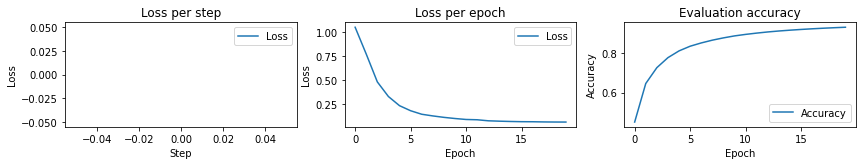

In [6]:
for i in range(num_epochs):

    epoch_loss = train_epoch(model, train_dataloader, opt, lr_scheduler, criterion, logger)
    acc = eval_epoch(model, test_dataloader, m1)
    with open("/home/beast/Desktop/vlassis/retrieval2/accuracy.txt", "a") as f:
        f.write(f"epoch_loss: {epoch_loss}, acc: {acc}\n")
    logger.on_epoch([epoch_loss, acc])

In [7]:
save_path = "/home/beast/Desktop/vlassis/retrieval2/checkpoints/CLS_0415_T7_shapenet.pt"
torch.save(model.state_dict(), save_path)

In [8]:
len(train_dataloader)

106